<center>
<h1> Linear Regression Case Study
</center>

### Steps for Regression Modeling:
1. Business problem definition - One of major automobile company would like to design new product which can improve the sales. Inorder to define the product, they want to understand/identify drivers for the sales (what are the factors driving sales) and Predicting sales of different car models given driving factors. 
2. Convert business problem into statistical problem  sales = F(sales attributes, product features, marketing info etc.)
3. Finding the right technique - Since it is predicting value (Regression Problem) problem so we can use OLS as one of the technique. We can also use other techniques like Decision Trees, Ensemble learning, KNN, SVM, ANN etc.
4. Data colletion(Y, X) - Identify the sources of information and collect the data
5. Consolidate the data - aggregate and consolidate the data at Model level/customer level/store level depends on business problem
6. Data preparation for modeling (create data audit report to identify the steps to perform as part of data preparation)
    a. missing value treatment
    b. outlier treatment
    c. dummy variable creation
7. Variable creation by using transformation and derived variable creation.
8. Basic assumptions (Normality, linearity, no outliers, homoscadasticity, no pattern in residuals, no auto correlation etc)
9. Variable reduction techniques (removing multicollinerity with the help of FA/PCA, correlation matrics, VIF)
10. Create dev and validation data sets (50:50 if you have more data else 70:30 or 80:20)
11. Modeling on dev data set (identify significant variables, model interpretation, check the signs and coefficients, multi-collinierity check, measures of good neess fit, final mathematical equation etc)
12. validating on validation data set (check the stability of model, scoring, decile analysis, cross validation etc.)
13. Output interpretation and derive insights (understand the limitations of the model and define strategy to implementation)
14. convert statistical solution into business solutions (implementation, model monitoring etc)


## Importing Packages

In [1]:
import pandas as pd
import numpy as np

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
import scipy.stats as stats

In [4]:
#pip install pandas_profiling
import pandas_profiling

In [5]:
from sklearn.model_selection import train_test_split

import statsmodels.formula.api as smf          #for creating statistical models only
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, r2_score

## Creating UDFs

In [6]:
# Create Data audit Report for continuous variables
def continuous_var_summary(x):
    return pd.Series([x.count(), x.shape[0] - x.count(), x.sum(), x.mean(), x.median(), x.std(),
                         x.var(), x.min(), x.quantile(0.01), x.quantile(0.05), x.quantile(0.1), x.quantile(0.25),
                             x.quantile(), x.quantile(0.75), x.quantile(0.90), x.quantile(0.95), x.quantile(0.99),
                                 x.max()],
                     index = ['N', 'NMISS', 'SUM', 'MEAN','MEDIAN', 'STD', 'VAR', 'MIN', 'P1', 
                               'P5' ,'P10' ,'P25' ,'P50' ,'P75' ,'P90' ,'P95' ,'P99' ,'MAX'])

In [7]:
# Create Data audit Report for categorical variables
def categorical_var_summary(x):
    Mode = x.value_counts().reset_index()
    return pd.Series([x.count(), x.isnull().sum(), Mode.iloc[0, 0], Mode.iloc[0, 1],
                         round(Mode.iloc[0, 1] * 100/ x.count(), 2)],
                     index = ['N', 'NMISS', 'MODE', 'FREQ', 'PERCENT'])

In [8]:
# Missing value imputation for categorical and continuous variables
def missing_imputation(x, stats = 'mean'):
    if (x.dtypes == 'float64') | (x.dtypes == 'int64'):
        x = x.fillna(x.mean()) if stats == 'mean' else x.fillna(x.median())
    else:
        x = x.fillna(x.mode())
    return x

In [9]:
# An utility function to create dummy variable
def create_dummies(df, colname):
    col_dummies = pd.get_dummies(df[colname], prefix = colname, drop_first = True)
    df = pd.concat([df, col_dummies], axis = 1)
    df.drop(colname, axis = 1, inplace = True )
    return df

## Import Data

In [10]:
cars = pd.read_csv("Car_sales.csv")

## Data Inspection

In [11]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157 entries, 0 to 156
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Manufacturer            157 non-null    object 
 1   Model                   157 non-null    object 
 2   Sales_in_thousands      157 non-null    float64
 3   four_year_resale_value  121 non-null    float64
 4   Vehicle_type            157 non-null    object 
 5   Price_in_thousands      155 non-null    float64
 6   Engine_size             156 non-null    float64
 7   Horsepower              156 non-null    float64
 8   Wheelbase               156 non-null    float64
 9   Width                   156 non-null    float64
 10  Length                  156 non-null    float64
 11  Curb_weight             155 non-null    float64
 12  Fuel_capacity           156 non-null    float64
 13  Fuel_efficiency         154 non-null    float64
 14  Latest_Launch           157 non-null    ob

In [12]:
# Creating an object of pandas profiling for cars dataset
report = pandas_profiling.ProfileReport(cars)

In [13]:
# report.to_file('ProfileReport.html')

In [14]:
#Separating Categorical and Continuous Varible
cars_conti_vars = cars.loc[: , (cars.dtypes == 'float64') | (cars.dtypes == 'int64')]
cars_cat_vars = cars.loc[: , (cars.dtypes == 'object')]

# Alternate/Simpler Way
# cars_conti_vars = cars.select_dtypes(['float64', 'int64'])
# cars_cat_vars = cars.select_dtypes(["object"])

In [15]:
# Summary of the data
# Also .describe can be used
cars_conti_vars.apply(continuous_var_summary).round(1)

,Sales_in_thousands,four_year_resale_value,Price_in_thousands,Engine_size,Horsepower,Wheelbase,Width,Length,Curb_weight,Fuel_capacity,Fuel_efficiency,Power_perf_factor
N,157.0,121.0,155.0,156.0,156.0,156.0,156.0,156.0,155.0,156.0,154.0,155.0
NMISS,0.0,36.0,2.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,3.0,2.0
SUM,8320.7,2186.8,4245.6,477.5,29008.0,16768.0,11099.4,29225.6,523.6,2800.5,3672.0,11941.8
MEAN,53.0,18.1,27.4,3.1,185.9,107.5,71.1,187.3,3.4,18.0,23.8,77.0
MEDIAN,29.4,14.2,22.8,3.0,177.5,107.0,70.6,187.9,3.3,17.2,24.0,72.0
STD,68.0,11.5,14.4,1.0,56.7,7.6,3.5,13.4,0.6,3.9,4.3,25.1
VAR,4628.0,131.2,206.0,1.1,3214.9,58.4,11.9,180.4,0.4,15.1,18.3,632.2
MIN,0.1,5.2,9.2,1.0,55.0,92.6,62.6,149.4,1.9,10.3,15.0,23.3
P1,0.9,6.2,10.2,1.6,96.4,92.9,66.1,154.9,2.2,11.9,15.0,38.5
P5,1.9,7.8,12.5,1.8,114.5,95.9,66.5,163.7,2.4,12.5,16.6,46.2


In [16]:
# cars_cat_vars.describe()
cars_cat_vars.apply(categorical_var_summary)

,Manufacturer,Model,Vehicle_type,Latest_Launch
N,157,157,157,157
NMISS,0,0,0,0
MODE,Dodge,Neon,Passenger,2/18/2011
FREQ,11,2,116,2
PERCENT,7.01,1.27,73.89,1.27


## Outliers treatment

In [17]:
cars_conti_vars = cars_conti_vars.apply(lambda x : x.clip(lower = x.dropna().quantile(0.01), upper = x.quantile(0.99)))

In [18]:
cars_conti_vars.apply(continuous_var_summary).round(1)

,Sales_in_thousands,four_year_resale_value,Price_in_thousands,Engine_size,Horsepower,Wheelbase,Width,Length,Curb_weight,Fuel_capacity,Fuel_efficiency,Power_perf_factor
N,157.0,121.0,155.0,156.0,156.0,156.0,156.0,156.0,155.0,156.0,154.0,155.0
NMISS,0.0,36.0,2.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,3.0,2.0
SUM,8025.5,2180.4,4236.0,475.8,28910.3,16760.1,11102.4,29223.9,523.8,2799.9,3660.0,11911.7
MEAN,51.1,18.0,27.3,3.1,185.3,107.4,71.2,187.3,3.4,17.9,23.8,76.8
MEDIAN,29.4,14.2,22.8,3.0,177.5,107.0,70.6,187.9,3.3,17.2,24.0,72.0
STD,57.7,11.2,14.1,1.0,52.8,7.4,3.4,13.1,0.6,3.8,4.0,23.8
VAR,3331.9,125.0,197.8,1.0,2789.6,55.1,11.5,172.1,0.4,14.6,16.0,568.6
MIN,0.9,6.2,10.2,1.6,96.4,92.9,66.1,154.9,2.2,11.9,15.0,38.5
P1,0.9,6.4,10.5,1.6,98.4,93.0,66.3,156.2,2.2,11.9,15.0,39.3
P5,1.9,7.8,12.5,1.8,114.5,95.9,66.5,163.7,2.4,12.5,16.6,46.2


## Missing value treatment

In [19]:
cars_conti_vars = cars_conti_vars.apply(missing_imputation)
cars_cat_vars = cars_cat_vars.apply(missing_imputation)

In [20]:
cars_conti_vars.apply(continuous_var_summary).round(1)

,Sales_in_thousands,four_year_resale_value,Price_in_thousands,Engine_size,Horsepower,Wheelbase,Width,Length,Curb_weight,Fuel_capacity,Fuel_efficiency,Power_perf_factor
N,157.0,157.0,157.0,157.0,157.0,157.0,157.0,157.0,157.0,157.0,157.0,157.0
NMISS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SUM,8025.5,2829.1,4290.6,478.9,29095.6,16867.5,11173.6,29411.3,530.5,2817.8,3731.3,12065.4
MEAN,51.1,18.0,27.3,3.1,185.3,107.4,71.2,187.3,3.4,17.9,23.8,76.8
MEDIAN,29.4,17.7,23.4,3.0,180.0,107.0,70.6,187.8,3.4,17.2,24.0,72.3
STD,57.7,9.8,14.0,1.0,52.6,7.4,3.4,13.1,0.6,3.8,4.0,23.7
VAR,3331.9,96.2,195.3,1.0,2771.7,54.8,11.4,171.0,0.4,14.5,15.7,561.3
MIN,0.9,6.2,10.2,1.6,96.4,92.9,66.1,154.9,2.2,11.9,15.0,38.5
P1,0.9,6.9,10.5,1.6,98.4,93.0,66.3,156.3,2.2,11.9,15.0,39.3
P5,1.9,8.4,12.5,1.8,114.6,95.9,66.5,163.7,2.4,12.5,16.8,46.3


## Handling categorical features

scikit-learn expects all features to be numeric. So how do we include a categorical feature in our model?

- **Ordered categories:** transform them to sensible numeric values (example: small=1, medium=2, large=3)
- **Unordered categories:** use dummy encoding (0/1)

What are the categorical features in our dataset?

- **Ordered categories:** weather (already encoded with sensible numeric values)
- **Unordered categories:** season (needs dummy encoding), holiday (already dummy encoded), workingday (already dummy encoded)

For season, we can't simply leave the encoding as 1 = spring, 2 = summer, 3 = fall, and 4 = winter, because that would imply an **ordered relationship**. Instead, we create **multiple dummy variables:**

In [21]:
cars_cat_vars.Manufacturer.value_counts().count()

30

In [22]:
cars_cat_vars.Vehicle_type.value_counts().count()

2

In [23]:
# Can also use the create_dummy udf
cars_cat_vars = pd.get_dummies(cars_cat_vars[["Manufacturer", "Vehicle_type"]], drop_first = True)

In [24]:
cars_cat_vars

,Manufacturer_Audi,Manufacturer_BMW,Manufacturer_Buick,Manufacturer_Cadillac,Manufacturer_Chevrolet,Manufacturer_Chrysler,Manufacturer_Dodge,Manufacturer_Ford,Manufacturer_Honda,Manufacturer_Hyundai,...,Manufacturer_Plymouth,Manufacturer_Pontiac,Manufacturer_Porsche,Manufacturer_Saab,Manufacturer_Saturn,Manufacturer_Subaru,Manufacturer_Toyota,Manufacturer_Volkswagen,Manufacturer_Volvo,Vehicle_type_Passenger
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
153,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
154,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
155,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1


## Final data analysis

In [25]:
cars_new = pd.concat([cars_conti_vars, cars_cat_vars], axis = 1)
cars_new

,Sales_in_thousands,four_year_resale_value,Price_in_thousands,Engine_size,Horsepower,Wheelbase,Width,Length,Curb_weight,Fuel_capacity,...,Manufacturer_Plymouth,Manufacturer_Pontiac,Manufacturer_Porsche,Manufacturer_Saab,Manufacturer_Saturn,Manufacturer_Subaru,Manufacturer_Toyota,Manufacturer_Volkswagen,Manufacturer_Volvo,Vehicle_type_Passenger
0,16.919,16.360000,21.500000,1.8,140.0,101.2,67.3,172.4,2.639,13.2,...,0,0,0,0,0,0,0,0,0,1
1,39.384,19.875000,28.400000,3.2,225.0,108.1,70.3,192.9,3.517,17.2,...,0,0,0,0,0,0,0,0,0,1
2,14.114,18.225000,27.328745,3.2,225.0,106.9,70.6,192.0,3.470,17.2,...,0,0,0,0,0,0,0,0,0,1
3,8.588,29.725000,42.000000,3.5,210.0,114.6,71.4,196.6,3.850,18.0,...,0,0,0,0,0,0,0,0,0,1
4,20.397,22.255000,23.990000,1.8,150.0,102.6,68.2,178.0,2.998,16.4,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152,3.545,18.020008,24.400000,1.9,160.0,100.5,67.6,176.6,3.042,15.8,...,0,0,0,0,0,0,0,0,1,1
153,15.245,18.020008,27.500000,2.4,168.0,104.9,69.3,185.9,3.208,17.9,...,0,0,0,0,0,0,0,0,1,1
154,17.531,18.020008,28.800000,2.4,168.0,104.9,69.3,186.2,3.259,17.9,...,0,0,0,0,0,0,0,0,1,1
155,3.493,18.020008,45.500000,2.3,236.0,104.9,71.5,185.7,3.601,18.5,...,0,0,0,0,0,0,0,0,1,1


In [26]:
cars_new.shape

(157, 42)

## Assumption Check

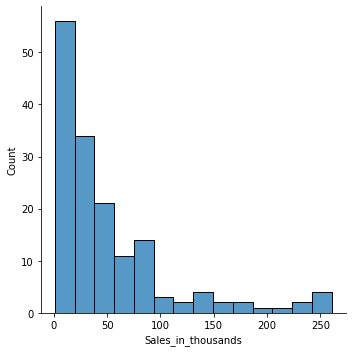

In [27]:
# Very first assumtion is that all the variables should be normally distributed, however that can't be possible
# However we have to be atleast strict about the dependant Y variable

# Distribution of variables
sns.displot(cars_new.Sales_in_thousands)
plt.show()
# this distribution is highly skewed

# Notes:
#-----------------------------------------------------
# 1. if we get skewed data, then we have to transform the data and there are multiple methods to go about it
# 2. most commonly used and which works on most of the data is log transformation
# 3. Ideally we can do this for each of the dependant variable as well, 
#    however it will depend on amount of data and the amount of analytical rigour
# 4. In no case we can proceed if dependant variable is not normal/near to normal distributed

In [28]:
cars_new.Sales_in_thousands.skew()

1.9924932920508793

In [29]:
cars_new['ln_sales_in_thousands'] = np.log(cars_new.Sales_in_thousands)

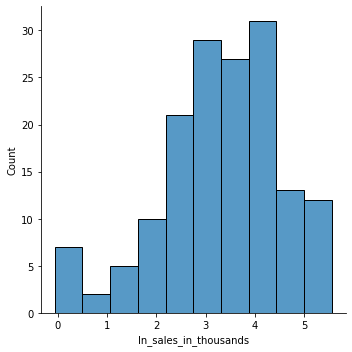

In [30]:
sns.displot(cars_new.ln_sales_in_thousands)
plt.show()

In [31]:
cars_new.ln_sales_in_thousands.skew()

-0.5925861100519006

In [32]:
corrm = cars_new.corr()
corrm.to_excel("corrm.xlsx")
corrm

,Sales_in_thousands,four_year_resale_value,Price_in_thousands,Engine_size,Horsepower,Wheelbase,Width,Length,Curb_weight,Fuel_capacity,...,Manufacturer_Pontiac,Manufacturer_Porsche,Manufacturer_Saab,Manufacturer_Saturn,Manufacturer_Subaru,Manufacturer_Toyota,Manufacturer_Volkswagen,Manufacturer_Volvo,Vehicle_type_Passenger,ln_sales_in_thousands
Sales_in_thousands,1.000000,-3.075381e-01,-0.361572,-0.014342,-0.259311,0.278280,0.093054,0.200997,-0.035282,0.044446,...,0.036853,-0.114192,-7.988584e-02,-0.054683,-2.181588e-02,0.133404,-0.056294,-1.333610e-01,-0.230252,0.799513
four_year_resale_value,-0.307538,1.000000e+00,0.832320,0.440258,0.679605,-0.037624,0.158211,0.025517,0.304378,0.284274,...,-0.071303,0.512245,4.484484e-17,-0.087128,5.774589e-17,-0.030552,-0.062450,2.124397e-16,0.076638,-0.479350
Price_in_thousands,-0.361572,8.323203e-01,1.000000,0.618230,0.849851,0.118080,0.328107,0.158161,0.527230,0.430942,...,-0.062676,0.352160,1.860392e-02,-0.170025,-4.839044e-02,-0.094643,-0.137820,5.158511e-02,0.042006,-0.578170
Engine_size,-0.014342,4.402582e-01,0.618230,1.000000,0.815010,0.518423,0.702618,0.576386,0.793937,0.698341,...,0.078278,0.016675,-1.047543e-01,-0.191415,-6.401942e-02,-0.108099,-0.221271,-1.531916e-01,-0.279272,-0.120983
Horsepower,-0.259311,6.796053e-01,0.849851,0.815010,1.000000,0.325247,0.538115,0.420472,0.637823,0.526554,...,-0.001225,0.231413,-1.693190e-02,-0.227139,-4.398854e-02,-0.115857,-0.244956,-1.198690e-02,-0.011910,-0.400528
Wheelbase,0.278280,-3.762379e-02,0.118080,0.518423,0.325247,1.000000,0.681402,0.837566,0.657133,0.659706,...,0.046301,-0.260846,-4.521823e-02,-0.083508,-9.218360e-02,-0.094079,-0.203652,-8.565596e-02,-0.383084,0.270203
Width,0.093054,1.582115e-01,0.328107,0.702618,0.538115,0.681402,1.000000,0.700153,0.710589,0.648557,...,0.042237,-0.060887,-7.315767e-02,-0.200799,-1.102499e-01,-0.115710,-0.187554,-9.484845e-02,-0.241472,0.038309
Length,0.200997,2.551744e-02,0.158161,0.576386,0.420472,0.837566,0.700153,1.000000,0.622789,0.561884,...,0.096592,-0.149884,-1.422854e-02,-0.061395,-5.953822e-02,-0.103610,-0.304533,-5.911793e-02,-0.129701,0.207226
Curb_weight,-0.035282,3.043781e-01,0.527230,0.793937,0.637823,0.657133,0.710589,0.622789,1.000000,0.868131,...,0.007662,-0.094627,-4.503929e-02,-0.221474,-2.013658e-02,-0.070768,-0.161960,-3.058882e-02,-0.519405,-0.051904
Fuel_capacity,0.044446,2.842737e-01,0.430942,0.698341,0.526554,0.659706,0.648557,0.561884,0.868131,1.000000,...,-0.001650,-0.034864,-7.424594e-03,-0.260342,-4.633177e-02,-0.011787,-0.170589,-6.026328e-03,-0.594758,-0.019549


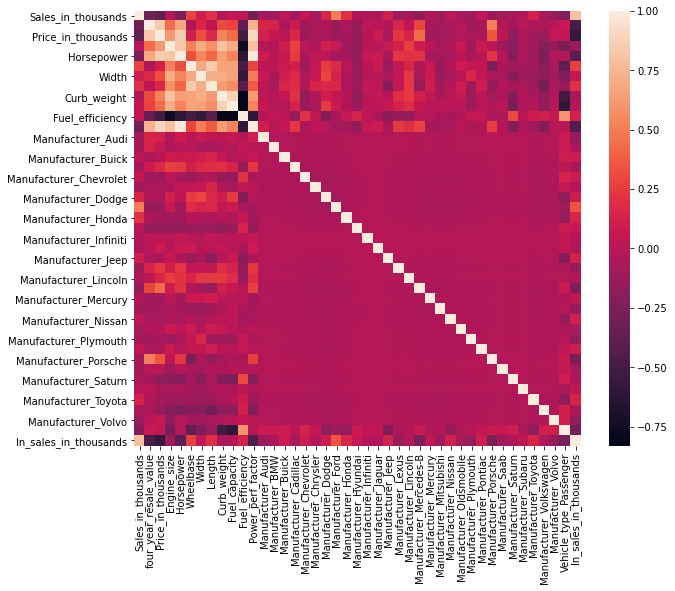

In [33]:
plt.figure(figsize = (10, 8))
sns.heatmap(cars_new.corr())
plt.show()

In [34]:
# dropping the variables based low correlation with Y
cars_new.drop(['Curb_weight', 'Fuel_capacity', 'Manufacturer_BMW', 'Manufacturer_Buick', 'Manufacturer_Jeep', 
        'Manufacturer_Cadillac', 'Manufacturer_Chevrolet', 'Manufacturer_Chrysler', 'Manufacturer_Hyundai', 
               'Manufacturer_Infiniti', 'Manufacturer_Jaguar', 'Manufacturer_Lincoln','Manufacturer_Mercury',
                   'Manufacturer_Oldsmobile', 'Manufacturer_Pontiac', 'Manufacturer_Saab', 'Manufacturer_Saturn',
                       'Manufacturer_Subaru','Manufacturer_Volkswagen', 'Manufacturer_Mercedes-B'], axis = 1, inplace = True)

In [35]:
# dropping variables with less variance in the data
# cars_new.drop(['Length', 'Width'], axis = 1, inplace = True)

### splitting data for model building

In [36]:
cars_new.columns

Index(['Sales_in_thousands', 'four_year_resale_value', 'Price_in_thousands',
       'Engine_size', 'Horsepower', 'Wheelbase', 'Width', 'Length',
       'Fuel_efficiency', 'Power_perf_factor', 'Manufacturer_Audi',
       'Manufacturer_Dodge', 'Manufacturer_Ford', 'Manufacturer_Honda',
       'Manufacturer_Lexus', 'Manufacturer_Mitsubishi', 'Manufacturer_Nissan',
       'Manufacturer_Plymouth', 'Manufacturer_Porsche', 'Manufacturer_Toyota',
       'Manufacturer_Volvo', 'Vehicle_type_Passenger',
       'ln_sales_in_thousands'],
      dtype='object')

In [37]:
# Splitting X-variables from the data set
feature_columns = cars_new.columns.difference(['ln_sales_in_thousands', 'Sales_in_thousands'])
feature_columns

Index(['Engine_size', 'Fuel_efficiency', 'Horsepower', 'Length',
       'Manufacturer_Audi', 'Manufacturer_Dodge', 'Manufacturer_Ford',
       'Manufacturer_Honda', 'Manufacturer_Lexus', 'Manufacturer_Mitsubishi',
       'Manufacturer_Nissan', 'Manufacturer_Plymouth', 'Manufacturer_Porsche',
       'Manufacturer_Toyota', 'Manufacturer_Volvo', 'Power_perf_factor',
       'Price_in_thousands', 'Vehicle_type_Passenger', 'Wheelbase', 'Width',
       'four_year_resale_value'],
      dtype='object')

In [38]:
# splitting train and test datasets
# for sklearn, we require 4 dataset (train_X, test_X, train_y, test_y)
train_X, test_X, train_y, test_y = train_test_split(cars_new[feature_columns],
                                                    cars_new['ln_sales_in_thousands'], test_size = 0.3, 
                                                    random_state = 12345)

In [39]:
# for statistical model, we require only 2 data set (train, test)
train, test = train_test_split(cars_new, test_size = 0.3, random_state = 12345)

In [40]:
# Number of obseravations
print("observations in train dataset:", len(train) , "| observations in test dataset:", len(test))

observations in train dataset: 109 | observations in test dataset: 48


## Form of linear regression

$y = \beta_0 + \beta_1x_1 + \beta_2x_2 + ... + \beta_nx_n$

- $y$ is the response
- $\beta_0$ is the intercept
- $\beta_1$ is the coefficient for $x_1$ (the first feature)
- $\beta_n$ is the coefficient for $x_n$ (the nth feature)

The $\beta$ values are called the **model coefficients**:

- These values are estimated (or "learned") during the model fitting process using the **least squares criterion**.
- Specifically, we are find the line (mathematically) which minimizes the **sum of squared residuals** (or "sum of squared errors").
- And once we've learned these coefficients, we can use the model to predict the response.

### Building the model

In [41]:
all_columns = " + ".join(feature_columns)

In [42]:
# Step 1 and Step 2: define Y, X and build a ols model
lm1 = smf.ols('''ln_sales_in_thousands ~ Fuel_efficiency  + 
                    Manufacturer_Plymouth  + Price_in_thousands +
                        Vehicle_type_Passenger + Wheelbase''', train).fit()

In [43]:
# Step 3: getting the summary output of the model
print(lm1.summary())

                              OLS Regression Results                             
Dep. Variable:     ln_sales_in_thousands   R-squared:                       0.500
Model:                               OLS   Adj. R-squared:                  0.476
Method:                    Least Squares   F-statistic:                     20.63
Date:                   Mon, 28 Jun 2021   Prob (F-statistic):           3.17e-14
Time:                           00:52:27   Log-Likelihood:                -142.69
No. Observations:                    109   AIC:                             297.4
Df Residuals:                        103   BIC:                             313.5
Df Model:                              5                                         
Covariance Type:               nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------

In [44]:
# Step-4: Prediction on training dataset
train['pred_sales'] = np.exp(lm1.predict(train))

<ipython-input-44-c85889ab77bd>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['pred_sales'] = np.exp(lm1.predict(train))


In [45]:
train[['Sales_in_thousands', 'pred_sales']].head()

,Sales_in_thousands,pred_sales
54,125.33800,34.343794
52,260.64532,32.760649
141,65.11900,81.927192
8,9.23100,17.454079
131,5.22300,57.722580


In [46]:
# Step-5: Prediction on testing dataset
test['pred_sales'] = np.exp(lm1.predict(test))

<ipython-input-46-47c89d004b73>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['pred_sales'] = np.exp(lm1.predict(test))


In [47]:
# Accuracy metrices
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

In [48]:
# Step-6: (A) MAPE: Mean Absolute Percentage Error
# MAPE = mean(abs(actual_Y - predict_Y)/actual_Y)

MAPE_train = mean_absolute_percentage_error(train.Sales_in_thousands, train.pred_sales)
MAPE_test = mean_absolute_percentage_error(test.Sales_in_thousands, test.pred_sales)

# Printing the result
print('MAPE of training data: ', MAPE_train,  ' | ', 'MAPE of testing data: ', MAPE_test)

MAPE of training data:  1.142567446883903  |  MAPE of testing data:  0.7495546013968525


In [49]:
# Step-6: (B) RMSE: Root Mean Squared Error

MSE_train = mean_squared_error(train.Sales_in_thousands, train.pred_sales)
MSE_test = mean_squared_error(test.Sales_in_thousands, test.pred_sales)

# Printing the result
print('MSE of training data: ', MSE_train,  ' | ', 'MSE of testing data: ', MSE_test)
print('RMSE of training data: ', np.sqrt(MSE_train),  ' | ', 'RMSE of testing data: ', np.sqrt(MSE_test))

MSE of training data:  2937.1028228662963  |  MSE of testing data:  1746.6277023005443
RMSE of training data:  54.19504426482459  |  RMSE of testing data:  41.79267522306444


In [50]:
# Correlation

stats.pearsonr(train.Sales_in_thousands, train.pred_sales)

(0.47890052547845324, 1.3818943569056204e-07)

In [91]:
plt.rcParams['figure.figsize'] = 10, 7.5
plt.rcParams['axes.grid'] = True

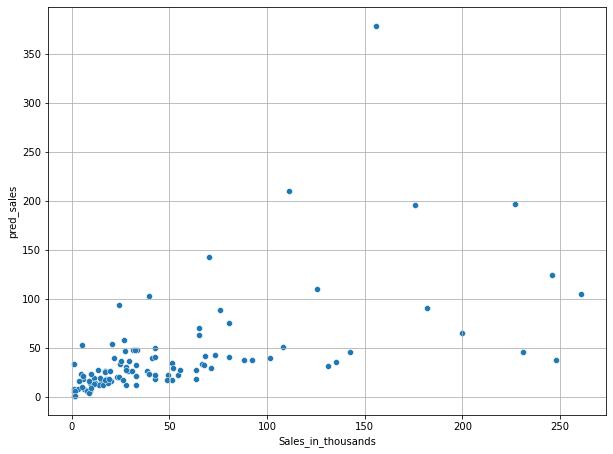

In [92]:
sns.scatterplot(x = train.Sales_in_thousands, y = train.pred_sales)
plt.show()

In [52]:
# Step 6: accuracy metrics (d. Decile Analysis: for validation of models - Business validation)

# create the 10 groups in the data
train['Deciles'] = pd.qcut(train['pred_sales'], 10, labels = False)
test['Deciles'] = pd.qcut(test['pred_sales'], 10, labels = False)


<ipython-input-52-31ef8f6ef8c2>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Deciles'] = pd.qcut(train['pred_sales'], 10, labels = False)
<ipython-input-52-31ef8f6ef8c2>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Deciles'] = pd.qcut(test['pred_sales'], 10, labels = False)


In [53]:
Decile_analysis_train = pd.pivot_table(train, values = ['pred_sales', 'Sales_in_thousands'], 
                                       index = 'Deciles').sort_index(ascending = False).reset_index()

In [54]:
# Decile Analysis for test data
Predicted_avg = test[['Deciles', 'pred_sales']].groupby(test.Deciles).mean().sort_index(ascending = False)['pred_sales']
Actual_avg = test[['Deciles', 'Sales_in_thousands']].groupby(test.Deciles).mean().sort_index(ascending = False)['Sales_in_thousands']
Decile_analysis_test = pd.concat([Predicted_avg, Actual_avg], axis = 1).reset_index()

In [55]:
Decile_analysis_train

,Deciles,Sales_in_thousands,pred_sales
0,9,111.481909,125.222664
1,8,58.632364,55.940103
2,7,76.648818,44.878431
3,6,86.811000,37.899691
4,5,84.200532,31.945303
5,4,33.047818,27.202269
6,3,21.041636,22.060372
7,2,25.660545,18.020243
8,1,15.663364,13.120874
9,0,4.061480,5.488021


In [56]:
Decile_analysis_test

,Deciles,pred_sales,Sales_in_thousands
0,9,129.927834,124.193264
1,8,53.134861,45.230600
2,7,40.718716,51.103200
3,6,35.799237,68.322250
4,5,29.008633,53.710400
5,4,25.112083,59.419600
6,3,22.890400,41.522500
7,2,18.961222,34.311000
8,1,12.836508,20.168600
9,0,3.739418,7.984656


## Model 2

In [57]:
'ln_sales_in_thousands ~ ' + ' + '.join(feature_columns)

'ln_sales_in_thousands ~ Engine_size + Fuel_efficiency + Horsepower + Length + Manufacturer_Audi + Manufacturer_Dodge + Manufacturer_Ford + Manufacturer_Honda + Manufacturer_Lexus + Manufacturer_Mitsubishi + Manufacturer_Nissan + Manufacturer_Plymouth + Manufacturer_Porsche + Manufacturer_Toyota + Manufacturer_Volvo + Power_perf_factor + Price_in_thousands + Vehicle_type_Passenger + Wheelbase + Width + four_year_resale_value'

In [58]:
# creating equation 
model_param = '''ln_sales_in_thousands ~ Fuel_efficiency + Manufacturer_Ford + Manufacturer_Plymouth +
                    Price_in_thousands + Vehicle_type_Passenger + Wheelbase'''

In [59]:
# Step 1 and Step 2: define Y, X and build a ols model
lm2 = smf.ols(model_param, train).fit()

In [60]:
print(lm2.summary())

                              OLS Regression Results                             
Dep. Variable:     ln_sales_in_thousands   R-squared:                       0.552
Model:                               OLS   Adj. R-squared:                  0.526
Method:                    Least Squares   F-statistic:                     20.99
Date:                   Mon, 28 Jun 2021   Prob (F-statistic):           6.74e-16
Time:                           00:52:27   Log-Likelihood:                -136.69
No. Observations:                    109   AIC:                             287.4
Df Residuals:                        102   BIC:                             306.2
Df Model:                              6                                         
Covariance Type:               nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------

In [61]:
# Predicting values on training and testing datasets
train['pred_sales'] = np.exp(lm2.predict(train))
test['pred_sales'] = np.exp(lm2.predict(test))

<ipython-input-61-63d6aafa3c9d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['pred_sales'] = np.exp(lm2.predict(train))
<ipython-input-61-63d6aafa3c9d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['pred_sales'] = np.exp(lm2.predict(test))


In [62]:
# MAPE
MAPE_train = mean_absolute_percentage_error(train.pred_sales, train.Sales_in_thousands)
MAPE_test = mean_absolute_percentage_error(test.pred_sales, test.Sales_in_thousands)

In [63]:
print('MAPE of training data: ', MAPE_train,  ' | ', 'MAPE of testing data: ', MAPE_test)

MAPE of training data:  0.7336250142669734  |  MAPE of testing data:  0.9534848976667165


## feature selection using f_regression

In [64]:
from sklearn.feature_selection import f_regression

In [65]:
# Feature selection based on importance
features = train_X
target = train_y
F_values, p_values = f_regression(features, target)

In [66]:
import itertools
f_reg_results = [(i, v, z) for i, v, z in itertools.zip_longest(features.columns, F_values,  ['%.3f' % p for p in p_values])]
f_reg_results=pd.DataFrame(f_reg_results, columns=['Variable','F_Value', 'P_Value'])
f_reg_results

,Variable,F_Value,P_Value
0,Engine_size,0.547392,0.461
1,Fuel_efficiency,2.058368,0.154
2,Horsepower,14.813868,0.000
3,Length,6.670120,0.011
4,Manufacturer_Audi,3.577542,0.061
5,Manufacturer_Dodge,3.849178,0.052
6,Manufacturer_Ford,13.642003,0.000
7,Manufacturer_Honda,6.424069,0.013
8,Manufacturer_Lexus,2.567134,0.112
9,Manufacturer_Mitsubishi,2.781523,0.098


In [67]:
f_reg_results = {
    "Variables": train_X.columns,
    "F_Values": F_values,
    "P_Value": p_values.round(3)
}
f_reg_results = pd.DataFrame(f_reg_results)
f_reg_results_new = f_reg_results.sort_values(["P_Value"])
f_reg_results

,Variables,F_Values,P_Value
0,Engine_size,0.547392,0.461
1,Fuel_efficiency,2.058368,0.154
2,Horsepower,14.813868,0.000
3,Length,6.670120,0.011
4,Manufacturer_Audi,3.577542,0.061
5,Manufacturer_Dodge,3.849178,0.052
6,Manufacturer_Ford,13.642003,0.000
7,Manufacturer_Honda,6.424069,0.013
8,Manufacturer_Lexus,2.567134,0.112
9,Manufacturer_Mitsubishi,2.781523,0.098


In [68]:
f_reg_results_new = f_reg_results_new[f_reg_results_new.P_Value <= 0.1]

In [98]:
len(feature_columns)

14

In [69]:
feature_columns = f_reg_results_new.Variables

In [70]:
'ln_sales_in_thousands ~ ' + ' + '.join(feature_columns)

'ln_sales_in_thousands ~ four_year_resale_value + Power_perf_factor + Horsepower + Manufacturer_Ford + Price_in_thousands + Manufacturer_Porsche + Wheelbase + Length + Vehicle_type_Passenger + Manufacturer_Honda + Manufacturer_Dodge + Manufacturer_Audi + Manufacturer_Plymouth + Manufacturer_Mitsubishi'

In [78]:
model_param = '''ln_sales_in_thousands ~ Manufacturer_Ford + Price_in_thousands + Wheelbase + 
                    Manufacturer_Plymouth + Vehicle_type_Passenger'''

In [79]:
lm3 = smf.ols(model_param, train).fit()
print(lm3.summary())

                              OLS Regression Results                             
Dep. Variable:     ln_sales_in_thousands   R-squared:                       0.523
Model:                               OLS   Adj. R-squared:                  0.500
Method:                    Least Squares   F-statistic:                     22.58
Date:                   Mon, 28 Jun 2021   Prob (F-statistic):           3.12e-15
Time:                           01:07:34   Log-Likelihood:                -140.17
No. Observations:                    109   AIC:                             292.3
Df Residuals:                        103   BIC:                             308.5
Df Model:                              5                                         
Covariance Type:               nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------